In [2]:
# python dependences:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import numpy as np

import healpy as hp
import pickle

import pandas as pd
from collections import OrderedDict

import yaml

import matplotlib
cmap = matplotlib.cm.get_cmap('plasma')
matplotlib.rcParams.update({'font.size': 15})

In [3]:
import sys
sys.path.insert(0, '/global/homes/q/qhang/desc/notebooks_for_analysis/')
import spatial_var_functions as svf
import measure_properties_with_systematics as mp

# Photo-z vs true-z

In [30]:
# load the data set:
samp={}
samp_snr={}
samp_odds={}

gold_i_10yr=25.3
for year in [1,3,5]:
    samp[year]={}
    samp_snr[year]={}
    samp_odds[year]={}
    
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    
    root=f'/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y{year}/'
    for q in [0,9]:
        fpz = root + f'bpz/roman-rubin_sample_obs_cal-coaddm5-i-qtl-{q}-meanApsf-theta_eff-zmode.pkl'
        fcat = root + f'roman-rubin_sample_obs_cal-coaddm5-i-qtl-{q}-meanApsf-theta_eff.pkl'
        cat = svf.dump_load(fcat)
        #cat = cat.drop(columns="index").reset_index(drop=True)
        pz = svf.dump_load(fpz)
        pz = pd.DataFrame(data={"z_mode": pz[:,0], "odds": pz[:,1]}, index=np.arange(len(cat)))
        cat = pd.concat([cat, pz], axis=1)
        
        fpz = root + f'fzb/roman-rubin_sample_obs_cal-coaddm5-i-qtl-{q}-meanApsf-theta_eff-zmode.pkl'
        pz = svf.dump_load(fpz)
        pz = pd.DataFrame(data={"z_mode_fzb": pz[:,0]}, index=np.arange(len(cat)))
        cat = pd.concat([cat, pz], axis=1)
        
        #cat2 = svf.select_data_with_cuts(cat, i_lim=24.1, snr_lim=10)
        # select i-band first
        ind1=cat["ObsMag_i"]<gold_i
        snr=1/(10**(cat["ObsMagErr_i"]/2.5)-1)
        ind2=snr>=10
        ind3 = cat["odds"]>=0.9

        samp[year][q]=[cat["z_mode"][ind1], cat["redshift"][ind1], cat["z_mode_fzb"][ind1]]
        samp_snr[year][q]=[cat["z_mode"][ind1*ind2], cat["redshift"][ind1*ind2],
                          cat["z_mode_fzb"][ind1*ind2]]
        samp_odds[year][q]=[cat["z_mode"][ind1*ind2*ind3], 
                            cat["redshift"][ind1*ind2*ind3]]

In [31]:
for year in [1,3,5]:
    print(len(samp_odds[year][0][0])/len(samp_snr[year][0][0]))

0.1766138136721317
0.2352193928704535
0.27352239819288976


In [32]:
for year in [1,3,5]:
    print(len(samp_odds[year][9][0])/len(samp_snr[year][9][0]))

0.26244124406666125
0.42676138511046613
0.424364592462752


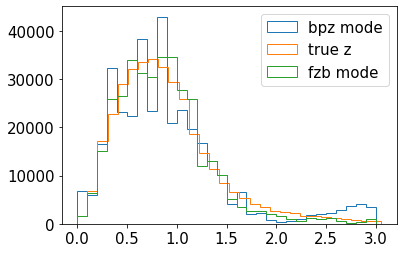

In [6]:
#plt.scatter(samp[year][q][0][:5],samp[year][q][1][:5])
#print(samp[year][q][0][:5], samp[year][q][1][:5])
cc=plt.hist(samp[year][q][0],bins=30,histtype='step',label="bpz mode")
cc=plt.hist(samp[year][q][1],bins=30,histtype='step',label="true z")
cc=plt.hist(samp[year][q][2],bins=30,histtype='step',label="fzb mode")
plt.legend()

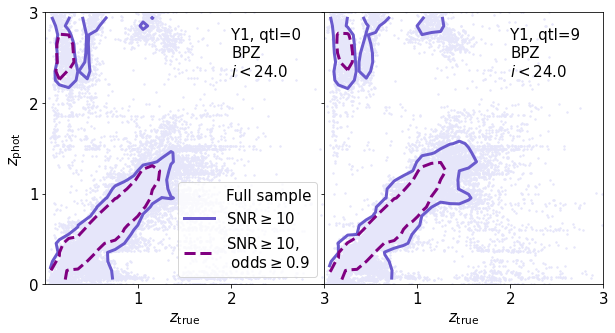

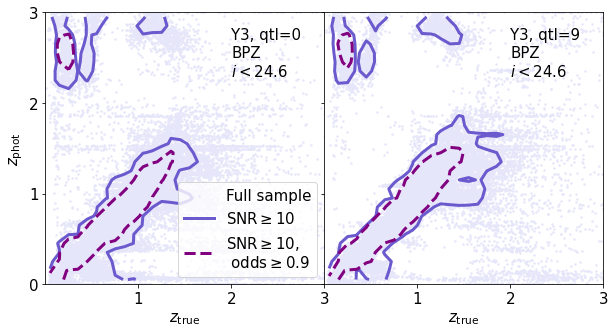

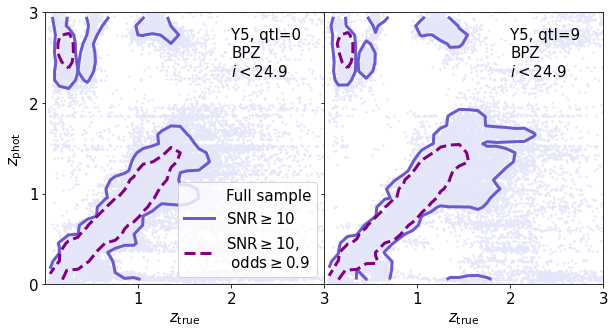

In [33]:
for jj,year in enumerate([1,3,5]):
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharey=True)
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    for ii, q in enumerate([0,9]):
        plt.sca(axarr[ii])
        plt.scatter(samp[year][q][1][::5], samp[year][q][0][::5], s=2, 
                    color='lavender', label="Full sample")
        
        # plot contours for snr selection and odds selection:
        cc = np.histogram2d(samp_snr[year][q][1],samp_snr[year][q][0],bins=[30,30],
                           range=[[0,3],[0,3]])
        xx=(cc[1][1:]+cc[1][:-1])/2.
        yy=(cc[2][1:]+cc[2][:-1])/2.
        zz=cc[0]/np.sum(cc[0].flatten())
        # find levels including 90% of the sample
        sortz = np.sort(zz.flatten())
        num = np.cumsum(sortz)
        ind=np.where(num > 0.05)[0][0]
        levels=sortz[ind]
        CS = axarr[ii].contour(xx,yy,zz.T,levels=[levels], colors='slateblue', 
                               linewidths=3)
        plt.plot([0],[0],color='slateblue', lw=3, label="SNR$\\geq10$")
        # plot contours for snr selection and odds selection:
        cc = np.histogram2d(samp_odds[year][q][1],samp_odds[year][q][0],bins=[30,30],
                           range=[[0,3],[0,3]])
        xx=(cc[1][1:]+cc[1][:-1])/2.
        yy=(cc[2][1:]+cc[2][:-1])/2.
        zz=cc[0]/np.sum(cc[0].flatten())
        # find levels including 90% of the sample
        sortz = np.sort(zz.flatten())
        num = np.cumsum(sortz)
        ind=np.where(num > 0.05)[0][0]
        levels=sortz[ind]
        CS = axarr[ii].contour(xx,yy,zz.T,levels=[levels], colors='purple', 
                               linewidths=3, linestyles='dashed')
        plt.plot([0],[0],color='purple', lw=3, ls='--', label="SNR$\\geq10$, \n odds$\\geq0.9$")
        plt.xlim([0,3])
        plt.ylim([0,3])
        plt.xticks([1,2,3])
        plt.xlabel("$z_{\\rm true}$")
        plt.text(2,2.7,f"Y{year}, qtl={q}")
        plt.text(2,2.5,"BPZ")
        plt.text(2,2.3,f"$i<{gold_i}$")
        if ii==0:
            plt.ylabel("$z_{\\rm phot}$")
            plt.legend(loc="lower right")
    plt.yticks([0,1,2,3])
    plt.subplots_adjust(wspace=0)
    plt.savefig(f"plots/photoz-specz-scatter-roman-rubin-Y{year}-bpz.png",
               bbox_inches="tight")

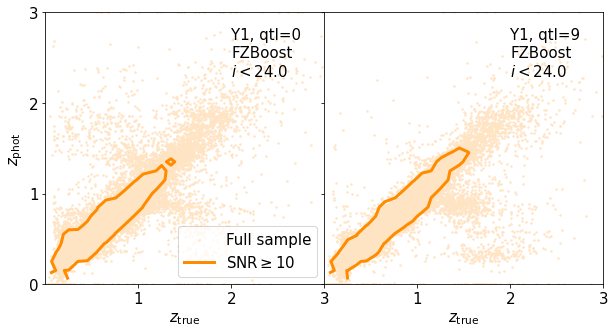

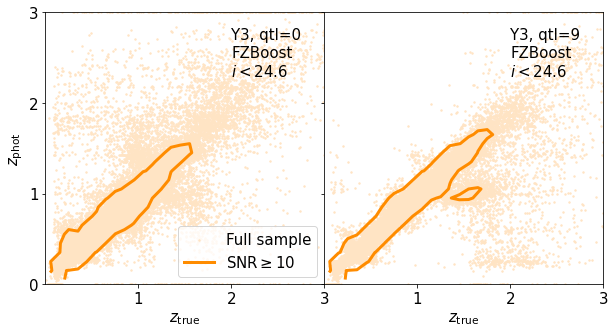

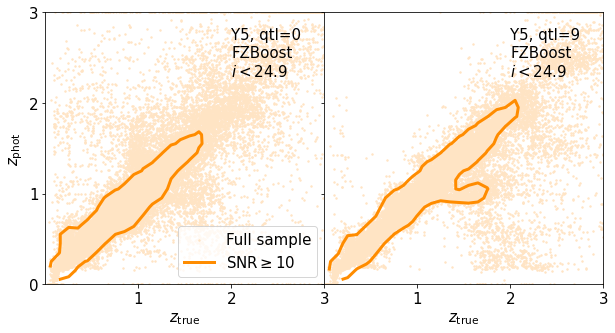

In [34]:
for jj,year in enumerate([1,3,5]):
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharey=True)
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    for ii, q in enumerate([0,9]):
        plt.sca(axarr[ii])
        plt.scatter(samp[year][q][1][::5], samp[year][q][2][::5], s=2, 
                    color='bisque', label="Full sample")
        

        # plot contours for snr selection and odds selection:
        cc = np.histogram2d(samp_snr[year][q][1],samp_snr[year][q][2],bins=[30,30],
                           range=[[0,3],[0,3]])
        xx=(cc[1][1:]+cc[1][:-1])/2.
        yy=(cc[2][1:]+cc[2][:-1])/2.
        zz=cc[0]/np.sum(cc[0].flatten())
        # find levels including 90% of the sample
        sortz = np.sort(zz.flatten())
        num = np.cumsum(sortz)
        ind=np.where(num > 0.05)[0][0]
        levels=sortz[ind]
        CS = axarr[ii].contour(xx,yy,zz.T,levels=[levels], colors='darkorange', 
                               linewidths=3)
        plt.plot([0],[0],color='darkorange', lw=3, label="SNR$\\geq10$")
        plt.xlim([0,3])
        plt.ylim([0,3])
        plt.xticks([1,2,3])
        plt.xlabel("$z_{\\rm true}$")
        plt.text(2,2.7,f"Y{year}, qtl={q}")
        plt.text(2,2.5,"FZBoost")
        plt.text(2,2.3,f"$i<{gold_i}$")
        if ii==0:
            plt.ylabel("$z_{\\rm phot}$")
            plt.legend(loc="lower right")

    plt.yticks([0,1,2,3])
    plt.subplots_adjust(wspace=0)
    plt.savefig(f"plots/photoz-specz-scatter-roman-rubin-Y{year}-fzb.png",
               bbox_inches="tight")

In [35]:
# print mean, scatter, outlier rates

def pz_stats(zspec,zphot):
    
    stats=[]
    
    z_spec = np.copy(zspec)
    z_phot=np.copy(zphot)
    x = np.arange(0,5.4,0.05)

    # define differences of >0.15*(1+z) as non-Gaussian 'outliers'    
    outlier_upper = x + 0.15*(1+x)
    outlier_lower = x - 0.15*(1+x)

    mask = np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15
    notmask = ~mask 
    
    #Standard Deviation of the predicted redshifts compared to the data:
    std_result = np.std((z_phot - z_spec)/(1 + z_spec), ddof=1)

    #Normalized MAD (Median Absolute Deviation):
    nmad = 1.48 * np.median(np.abs((z_phot - z_spec)/(1 + z_spec)))

    #Percentage of delta-z > 0.15(1+z) outliers:
    eta = np.sum(np.abs((z_phot - z_spec)/(1 + z_spec)) > 0.15)/len(z_spec)
    
    #Median offset (normalized by (1+z); i.e., bias:
    bias = np.median(((z_phot - z_spec)/(1 + z_spec)))
    sigbias=std_result/np.sqrt(0.64*len(z_phot))
    
    #print('bias, std, snmad, outlier f')
    s = f"& ${round(bias,3)}$ & ${round(std_result,3)}$ & ${round(nmad,4)}$ & ${round((eta*100),1)}$\%"
    
    return s

In [36]:
print("BPZ")
print("full, snr, odds")
for year in [1,3,5]:
    print(f"year: {year}")
    print('bias, std, snmad, outlier f')
    string = ""
    for ii, q in enumerate([0,9]):
        s=pz_stats(samp[year][q][1],samp[year][q][0])
        string += s + " "
    print(string)
    string = ""
    for ii, q in enumerate([0,9]):
        s=pz_stats(samp_snr[year][q][1],samp_snr[year][q][0])
        string += s + " "
    print(string)
    string = ""
    for ii, q in enumerate([0,9]):
        s=pz_stats(samp_odds[year][q][1],samp_odds[year][q][0])
        string += s + " "
    print(string)

BPZ
full, snr, odds
year: 1
bias, std, snmad, outlier f
& $-0.011$ & $0.411$ & $0.0772$ & $20.1$\% & $-0.011$ & $0.404$ & $0.0634$ & $15.5$\% 
& $-0.005$ & $0.444$ & $0.0632$ & $14.2$\% & $-0.009$ & $0.409$ & $0.0585$ & $12.6$\% 
& $-0.001$ & $0.446$ & $0.0431$ & $5.8$\% & $-0.006$ & $0.388$ & $0.0401$ & $4.5$\% 
year: 3
bias, std, snmad, outlier f
& $-0.013$ & $0.38$ & $0.077$ & $20.9$\% & $-0.011$ & $0.369$ & $0.0613$ & $14.3$\% 
& $-0.009$ & $0.399$ & $0.0612$ & $13.9$\% & $-0.01$ & $0.368$ & $0.0586$ & $12.1$\% 
& $-0.005$ & $0.388$ & $0.0407$ & $4.7$\% & $-0.008$ & $0.337$ & $0.0421$ & $4.2$\% 
year: 5
bias, std, snmad, outlier f
& $-0.013$ & $0.371$ & $0.0774$ & $21.3$\% & $-0.011$ & $0.353$ & $0.0666$ & $15.9$\% 
& $-0.009$ & $0.384$ & $0.062$ & $14.2$\% & $-0.009$ & $0.35$ & $0.0633$ & $13.5$\% 
& $-0.006$ & $0.372$ & $0.0403$ & $4.8$\% & $-0.007$ & $0.33$ & $0.0442$ & $4.4$\% 


In [37]:
print("FZB")
print("full, snr")
for year in [1,3,5]:

    print(f"year: {year}")
    print('bias, std, snmad, outlier f')
    string = ""
    for ii, q in enumerate([0,9]):
        s=pz_stats(samp[year][q][1],samp[year][q][2])
        string += s + " "
    print(string)
    string = ""
    for ii, q in enumerate([0,9]):
        s=pz_stats(samp_snr[year][q][1],samp_snr[year][q][2])
        string += s + " "
    print(string)

FZB
full, snr
year: 1
bias, std, snmad, outlier f
& $0.008$ & $0.122$ & $0.0479$ & $7.2$\% & $-0.006$ & $0.082$ & $0.0371$ & $4.2$\% 
& $0.008$ & $0.072$ & $0.041$ & $3.1$\% & $-0.004$ & $0.065$ & $0.0351$ & $2.4$\% 
year: 3
bias, std, snmad, outlier f
& $0.005$ & $0.145$ & $0.0408$ & $8.3$\% & $-0.004$ & $0.079$ & $0.0257$ & $4.2$\% 
& $0.005$ & $0.089$ & $0.0326$ & $3.1$\% & $-0.003$ & $0.065$ & $0.0247$ & $2.7$\% 
year: 5
bias, std, snmad, outlier f
& $0.004$ & $0.137$ & $0.038$ & $8.3$\% & $-0.003$ & $0.08$ & $0.0256$ & $4.7$\% 
& $0.004$ & $0.086$ & $0.0305$ & $3.4$\% & $-0.003$ & $0.068$ & $0.0244$ & $3.2$\% 


# n(z) disribution

In [4]:
bands = ['u','g','r','i','z','y']

savedir = "/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y3/"
sys_info = savedir + "ExgalM5-i-qtl-mean-weights.txt"

fin=np.loadtxt(sys_info)
qtl=fin[:,0]
mean_sys=fin[:-1,1]
qweights=fin[:-1,2]
print("mean_sys: ", mean_sys)
#print("qweights: ", qweights)

nquantiles=len(qtl)-1
print(qtl)

mean_sys:  [25.46029227 25.63755978 25.71517321 25.77605301 25.83087167 25.88211628
 25.93215028 25.98745145 26.06315664 26.17922218]
[24.45635701 25.58412269 25.68054968 25.74725094 25.80403718 25.85731518
 25.90701103 25.9576563  26.02081685 26.11157773 27.36975508]


In [9]:
# Load data:
# bpz:
root = '/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/'
# bpz snr>10
packed_stats_lens={}
for year in [1,3,5]:
    fname=root+f'y{year}/bpz/test-pz-with-i-band-coadd-Y{year}-snr-10.0-lens-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_lens[year]=yaml.load(stream,Loader=yaml.Loader)

# snr>10, odds>0.9
packed_stats_odds_lens={}
for year in [1,3,5]:
    fname=root+f'y{year}/bpz/test-pz-with-i-band-coadd-Y{year}-snr-10.0-odds-0.9-lens-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_odds_lens[year]=yaml.load(stream,Loader=yaml.Loader)
        
# fzb snr>10
packed_stats_fzb_lens={}
for year in [3,5]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-10.0-lens-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_fzb_lens[year]=yaml.load(stream,Loader=yaml.Loader)

# special case
for year in [1]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-10.0-lens-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_fzb_lens[year]=yaml.load(stream,Loader=yaml.Loader)

In [10]:
# source
# snr>10
packed_stats_source={}
for year in [1,3,5]:
    fname=root+f'y{year}/bpz/test-pz-with-i-band-coadd-Y{year}-snr-10.0-source-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_source[year]=yaml.load(stream,Loader=yaml.Loader)

# snr>10, odds>0.9
packed_stats_odds_source={}
for year in [1,3,5]:
    fname=root+f'y{year}/bpz/test-pz-with-i-band-coadd-Y{year}-snr-10.0-odds-0.9-source-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_odds_source[year]=yaml.load(stream,Loader=yaml.Loader)

# fzb snr>10
packed_stats_fzb_source={}
for year in [1,3,5]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-10.0-source-meanApsf-theta_eff.yml'
    with open(fname, "r") as stream:
        packed_stats_fzb_source[year]=yaml.load(stream,Loader=yaml.Loader)
        
# special case      
#for year in [1]:
#    fname=root+f'y{year}/fzb/old_model/test-pz-with-i-band-coadd-Y{year}-snr-10.0-source-meanApsf.yml'
#    with open(fname, "r") as stream:
#        packed_stats_fzb_source[year]=yaml.load(stream,Loader=yaml.Loader)

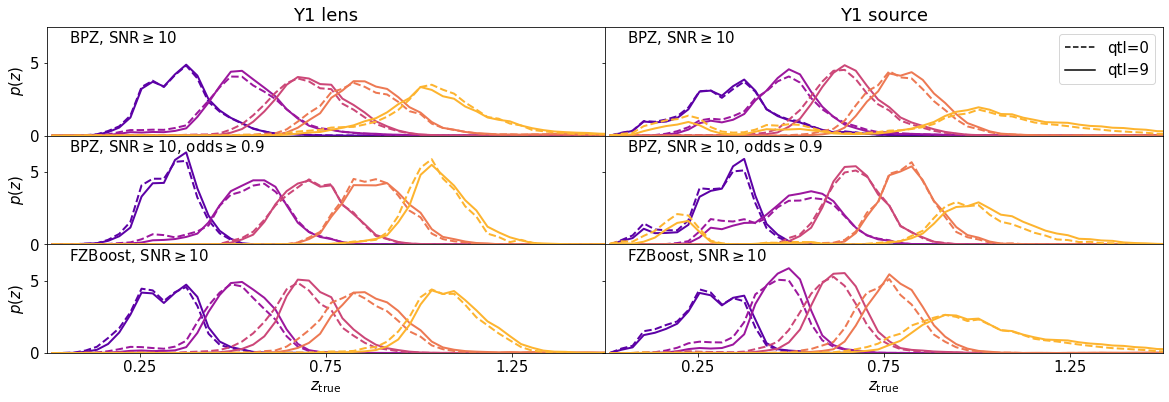

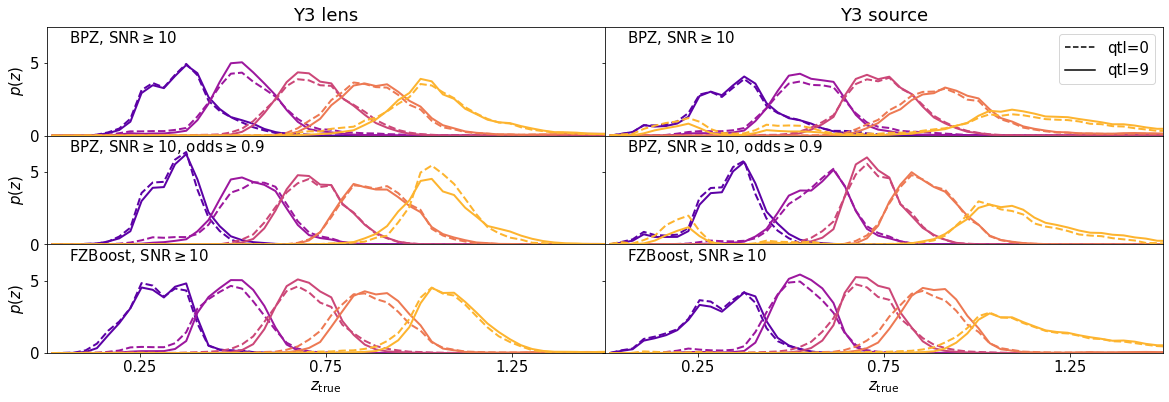

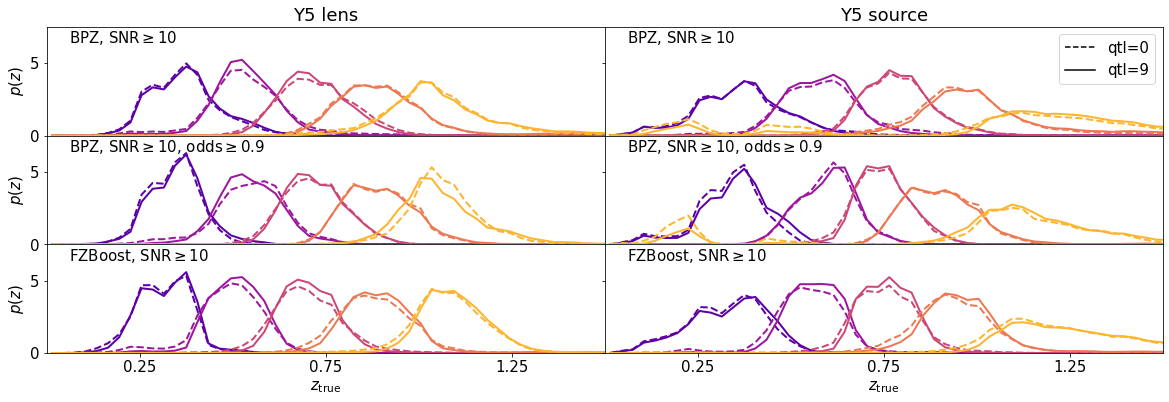

In [41]:
for year in [1,3,5]:
    fig,axarr=plt.subplots(3,2, figsize=[20,6],sharex=True, sharey=True)
    
    #fig.suptitle(f"Year {year}")
    stats=[packed_stats_lens[year], packed_stats_source[year],
           packed_stats_odds_lens[year], packed_stats_odds_source[year],
          packed_stats_fzb_lens[year], packed_stats_fzb_source[year]]
    
    title=[f"Y{year} lens", f"Y{year} source"]
    text=["BPZ, SNR$\\geq 10$", "BPZ, SNR$\\geq 10$", 
          "BPZ, SNR$\\geq 10$, odds$\\geq 0.9$", "BPZ, SNR$\\geq 10$, odds$\\geq 0.9$",
         "FZBoost, SNR$\\geq 10$", "FZBoost, SNR$\\geq 10$"]
    
    for ii in range(3):
        for jj in range(2):
            plt.sca(axarr[ii,jj])
            mm = ii*2+jj
            for kk in range(5):
                colorlab=(kk+1)/(5*1.2)
                
                # total case
                #nz = stats["tomo-%d"%(kk+1)]["nztot"]
                #y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                #plt.fill_between(nz[:,0], 0, y, color=cmap(colorlab),alpha=0.3, label='Full')

                # qtl 0 and 9
                nz = stats[mm]["tomo-%d"%(kk+1)]["nz"][0]
                y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                plt.plot(nz[:,0], y, color=cmap(colorlab),lw=2, ls="--")

                nz = stats[mm]["tomo-%d"%(kk+1)]["nz"][9]
                y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                plt.plot(nz[:,0], y, color=cmap(colorlab),lw=2)
            plt.xlim([0,1.5])
            plt.ylim([0,7.5])
            plt.xticks([0.25,0.75,1.25])
            if ii==0:
                plt.title(title[jj])
            if jj==0:
                plt.ylabel("$p(z)$")
            if ii==2:
                plt.xlabel("$z_{\\rm true}$")
            plt.text(0.06,6.4,text[mm])
            plt.yticks([0,5])
    
    plt.sca(axarr[0,1])
    plt.plot([0],[0],'k--',label="qtl=0")
    plt.plot([0],[0],'k-',label="qtl=9")
    plt.legend()
    plt.subplots_adjust(hspace=0, wspace=0)
    
    if year ==3:
        plt.savefig(f"plots/nz-baselinev3.3-y{year}-long.pdf",bbox_inches="tight")

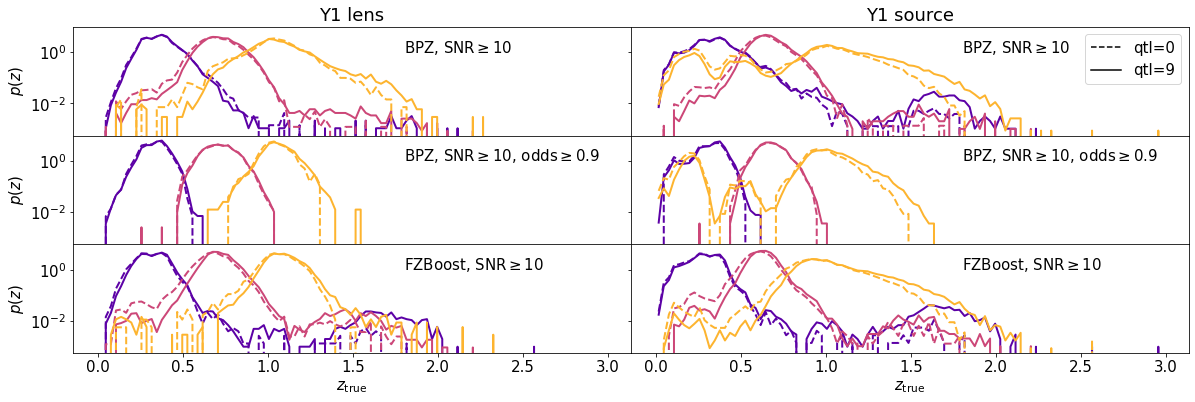

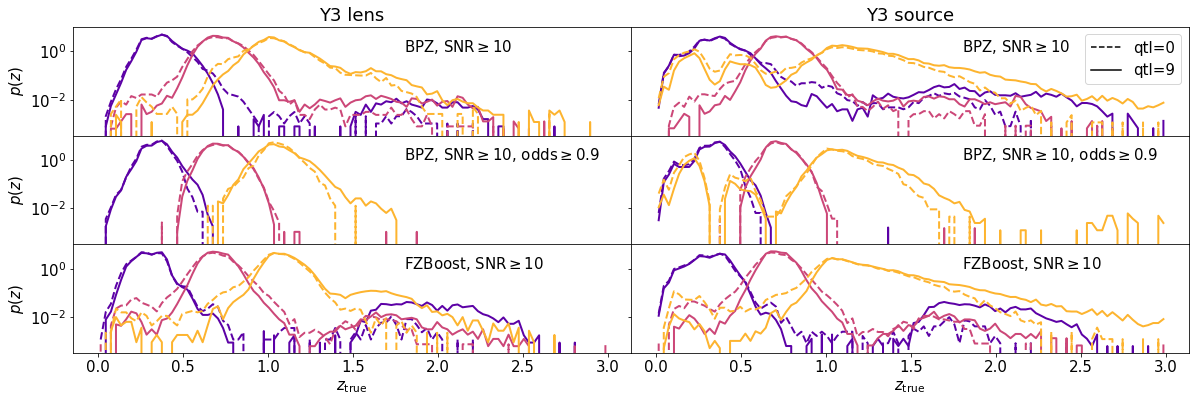

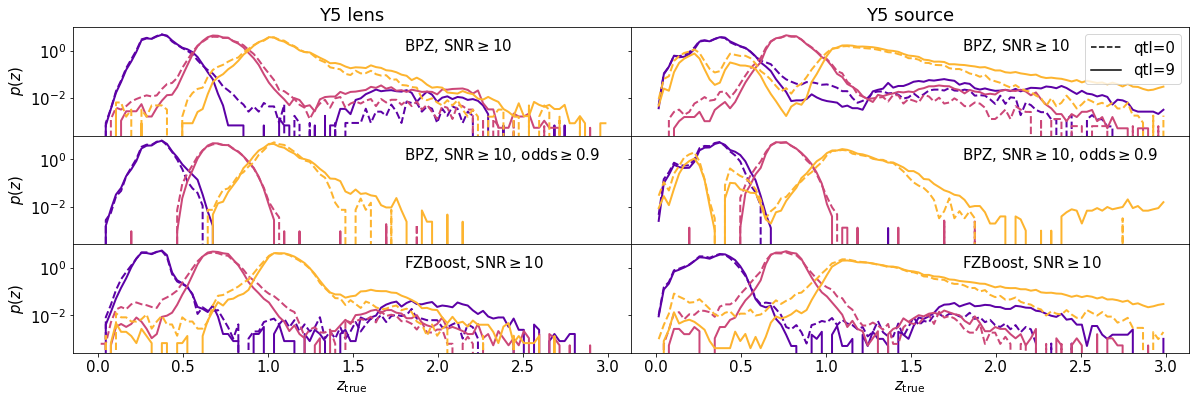

In [42]:
for year in [1,3,5]:
    fig,axarr=plt.subplots(3,2, figsize=[20,6],sharex=True, sharey=True)
    
    #fig.suptitle(f"Year {year}")
    stats=[packed_stats_lens[year], packed_stats_source[year],
           packed_stats_odds_lens[year], packed_stats_odds_source[year],
          packed_stats_fzb_lens[year], packed_stats_fzb_source[year]]
    
    title=[f"Y{year} lens", f"Y{year} source"]
    text=["BPZ, SNR$\\geq 10$", "BPZ, SNR$\\geq 10$", 
          "BPZ, SNR$\\geq 10$, odds$\\geq 0.9$", "BPZ, SNR$\\geq 10$, odds$\\geq 0.9$",
         "FZBoost, SNR$\\geq 10$", "FZBoost, SNR$\\geq 10$"]
    
    for ii in range(3):
        for jj in range(2):
            plt.sca(axarr[ii,jj])
            mm = ii*2+jj
            for kk in [0,2,4]:
                colorlab=(kk+1)/(5*1.2)
                
                # total case
                #nz = stats["tomo-%d"%(kk+1)]["nztot"]
                #y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                #plt.fill_between(nz[:,0], 0, y, color=cmap(colorlab),alpha=0.3, label='Full')

                # qtl 0 and 9
                nz = stats[mm]["tomo-%d"%(kk+1)]["nz"][0]
                y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                plt.plot(nz[:,0], y, color=cmap(colorlab),lw=2, ls="--")

                nz = stats[mm]["tomo-%d"%(kk+1)]["nz"][9]
                y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                plt.plot(nz[:,0], y, color=cmap(colorlab),lw=2)
            #plt.xlim([0,1.5])
            #plt.ylim([0,7.5])
            #plt.xticks([0.25,0.75,1.25])
            if ii==0:
                plt.title(title[jj])
            if jj==0:
                plt.ylabel("$p(z)$")
            if ii==2:
                plt.xlabel("$z_{\\rm true}$")
            plt.text(1.8,1,text[mm])
            #plt.yticks([0,5])
    
    plt.sca(axarr[0,1])
    plt.plot([0],[0],'k--',label="qtl=0")
    plt.plot([0],[0],'k-',label="qtl=9")
    plt.legend()
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.yscale("log")
    
    plt.savefig(f"plots/nz-baselinev3.3-y{year}-long-logy.pdf",bbox_inches="tight")

In [ ]:
# save the n(z) into directories
root = "/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/"
for year in [1,3,5]:
    
    savedir = root + f"y{year}/"
    
    stats=[packed_stats_lens[year], packed_stats_source[year],
           packed_stats_odds_lens[year], packed_stats_odds_source[year],
          packed_stats_fzb_lens[year], packed_stats_fzb_source[year]]
    
    #title=[f"Y{year} lens", f"Y{year} source"]
    #text=["BPZ, SNR$\\geq 10$", "BPZ, SNR$\\geq 10$", 
    #      "BPZ, SNR$\\geq 10$, odds$\\geq 0.9$", "BPZ, SNR$\\geq 10$, odds$\\geq 0.9$",
    #     "FZBoost, SNR$\\geq 10$", "FZBoost, SNR$\\geq 10$"]
    savename = ["bpz/distil/nz-lens-10-qtls", "bpz/distil/nz-source-10-qtls",
                "bpz/distil/nz-odds-lens-10-qtls", "bpz/distil/nz-odds-source-10-qtls",
                "fzb/distil/nz-lens-10-qtls", "fzb/distil/nz-source-10-qtls"]
    
    for mm in range(len(stats)):
        for kk in range(5):
            tomotag = f"-tomo-{kk}.txt"
            fname = savedir + savename[mm] + tomotag
            #print(fname)
            for ll in range(10):
                nz = stats[mm]["tomo-%d"%(kk+1)]["nz"][ll]
                y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                if ll == 0:
                    data_holder = np.c_[nz[:,0], y]
                elif ll>0:
                    data_holder = np.c_[data_holder, y]
            np.savetxt(fname, data_holder)

In [43]:
for year in [1,3,5]:

    stats=[packed_stats_lens[year], packed_stats_odds_lens[year],
           packed_stats_source[year],packed_stats_odds_source[year]]
    names=["bpz lens", "bpz lens odds", "bpz source", "bpz source odds"]
    
    print(f"Year {year}")
    print(names[:2])
    
    phrase=""
    for ss, nn in zip(stats[:2],names[:2]):
        N_lens=[]
        # number of objects as a function of depth:
        for ii in range(5):
            colorlab = (ii+1)/(5*1.2)
            N_galaxies=np.zeros(10)

            for q in range(10):
                nz = ss["tomo-%d"%(ii+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])#/totpix
            N_lens.append(N_galaxies)
        # print total number of lens weighted by pixels
        N_totlens=0
        #N_tot_zbin_list=[]
        
        for ii in range(5):
            N_tot_zbin=np.sum(N_lens[ii]*qweights)
            N_totlens+=N_tot_zbin
            #N_tot_zbin_list.append(round(N_tot_zbin,1))
            phrase += f" & ${round(N_tot_zbin,1)}$"
            
    print(phrase)
        #print("Total lens: ", N_totlens)
        #print("fraction in each bin: ", np.array(N_tot_zbin_list)/N_totlens)
        
    print(names[2:])
    phrase=""
    for ss, nn in zip(stats[2:],names[2:]):
        N_lens=[]
        # number of objects as a function of depth:
        for ii in range(5):
            colorlab = (ii+1)/(5*1.2)
            N_galaxies=np.zeros(10)

            for q in range(10):
                nz = ss["tomo-%d"%(ii+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])#/totpix
            N_lens.append(N_galaxies)
        # print total number of lens weighted by pixels
        N_totlens=0
        #N_tot_zbin_list=[]
        
        for ii in range(5):
            N_tot_zbin=np.sum(N_lens[ii]*qweights)
            N_totlens+=N_tot_zbin
            #N_tot_zbin_list.append(round(N_tot_zbin,1))
            phrase += f" & ${round(N_tot_zbin,1)}$"
            
    print(phrase)

Year 1
['bpz lens', 'bpz lens odds']
 & $28796.5$ & $32021.9$ & $35387.0$ & $24288.8$ & $8463.0$ & $7635.1$ & $6158.4$ & $10002.0$ & $6221.3$ & $1875.5$
['bpz source', 'bpz source odds']
 & $30534.5$ & $30534.5$ & $30534.5$ & $30534.6$ & $30534.7$ & $7042.0$ & $7042.0$ & $7042.0$ & $7042.0$ & $7042.0$
Year 3
['bpz lens', 'bpz lens odds']
 & $38988.1$ & $39330.9$ & $50523.5$ & $44645.0$ & $21978.0$ & $13904.9$ & $12239.9$ & $22208.5$ & $14705.3$ & $5822.9$
['bpz source', 'bpz source odds']
 & $48205.8$ & $48205.8$ & $48205.8$ & $48205.5$ & $48203.5$ & $15578.9$ & $15579.0$ & $15579.0$ & $15579.0$ & $15579.0$
Year 5
['bpz lens', 'bpz lens odds']
 & $44162.9$ & $43177.3$ & $58004.0$ & $54826.6$ & $31379.0$ & $17002.9$ & $15398.3$ & $28564.3$ & $19690.5$ & $8850.2$
['bpz source', 'bpz source odds']
 & $59745.5$ & $59747.1$ & $59746.1$ & $59745.0$ & $59725.6$ & $20746.7$ & $20746.8$ & $20746.7$ & $20746.8$ & $20744.1$


In [44]:
for year in [1,3,5]:

    stats=[packed_stats_fzb_lens[year], packed_stats_fzb_source[year]]
    names=["fzb lens", "fzb source"]
    
    print(f"Year {year}")
    print(names[:1])
    
    phrase=""
    for ss, nn in zip(stats[:1],names[:1]):
        N_lens=[]
        # number of objects as a function of depth:
        for ii in range(5):
            colorlab = (ii+1)/(5*1.2)
            N_galaxies=np.zeros(10)

            for q in range(10):
                nz = ss["tomo-%d"%(ii+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])#/totpix
            N_lens.append(N_galaxies)
        # print total number of lens weighted by pixels
        N_totlens=0
        #N_tot_zbin_list=[]
        
        for ii in range(5):
            N_tot_zbin=np.sum(N_lens[ii]*qweights)
            N_totlens+=N_tot_zbin
            #N_tot_zbin_list.append(round(N_tot_zbin,1))
            phrase += f" & ${round(N_tot_zbin,1)}$"
            
    print(phrase)

    print(names[1:])
    
    phrase=""
    for ss, nn in zip(stats[1:],names[1:]):
        N_lens=[]
        # number of objects as a function of depth:
        for ii in range(5):
            colorlab = (ii+1)/(5*1.2)
            N_galaxies=np.zeros(10)

            for q in range(10):
                nz = ss["tomo-%d"%(ii+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])#/totpix
            N_lens.append(N_galaxies)
        # print total number of lens weighted by pixels
        N_totlens=0
        #N_tot_zbin_list=[]
        
        for ii in range(5):
            N_tot_zbin=np.sum(N_lens[ii]*qweights)
            N_totlens+=N_tot_zbin
            #N_tot_zbin_list.append(round(N_tot_zbin,1))
            phrase += f" & ${round(N_tot_zbin,1)}$"
            
    print(phrase)

Year 1
['fzb lens']
 & $31054.7$ & $38964.9$ & $33717.0$ & $29871.8$ & $9104.6$
['fzb source']
 & $30534.6$ & $30534.5$ & $30534.5$ & $30534.5$ & $30534.7$
Year 3
['fzb lens']
 & $34498.5$ & $52662.6$ & $51564.7$ & $52858.0$ & $27561.2$
['fzb source']
 & $48205.9$ & $48205.8$ & $48205.8$ & $48205.9$ & $48203.1$
Year 5
['fzb lens']
 & $37286.1$ & $57641.9$ & $59009.5$ & $63214.3$ & $39344.7$
['fzb source']
 & $59747.0$ & $59747.1$ & $59747.0$ & $59747.2$ & $59721.0$


# Stuff vs depth

In [5]:
# load stuff:
bands = ['u','g','r','i','z','y']

qtl = {}
mean_sys = {}

for year in [1,3,5]:
    savedir = f"/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y{year}/"
    sys_info = savedir + "ExgalM5-i-qtl-mean-weights.txt"
    fin=np.loadtxt(sys_info)
    qtl[year]=fin[:,0]
    mean_sys[year]=fin[:-1,1]
    print("mean_sys: ", mean_sys[year])

qweights=fin[:-1,2]
nquantiles=len(qtl[year])-1
#print(qtl)
print(nquantiles)

mean_sys:  [24.9472875  25.09707362 25.16991563 25.2242605  25.26846982 25.30885744
 25.34801041 25.38904948 25.43852494 25.52863916]
mean_sys:  [25.46029227 25.63755978 25.71517321 25.77605301 25.83087167 25.88211628
 25.93215028 25.98745145 26.06315664 26.17922218]
mean_sys:  [25.74832672 25.88864028 25.95620054 26.01219159 26.06075136 26.10360003
 26.14284496 26.18387958 26.23397825 26.32683306]
10


In [6]:
one_sig_depth={1:[25.10831734035308, 25.432621792640763],
               3:[25.651075695696537, 26.05444784863291],
               5:[25.899129292179566, 26.227507341256548],}

two_sig_depth={1:[24.906584169584217, 25.554951298306165],
               3:[25.414553614216192, 26.211262818124343],
               5:[25.712960163359988, 26.355043617943952],}

gold_i_10yr=25.3

## Ngal vs depth

In [7]:
cmap2= matplotlib.cm.get_cmap('bone')

In [8]:
label1={}
for year in [1,3,5]:
    label1[year]=[]
    for kk in range(5):
        if year==1:
            label1[year].append('tomo-%d'%(kk+1))
        else:
            label1[year].append('')

label2={}
for year in [1,3,5]:
    label2[year]=[]
    for kk in range(5):
        if year==3:
            label2[year].append('tomo-%d'%(kk+1))
        else:
            label2[year].append('')

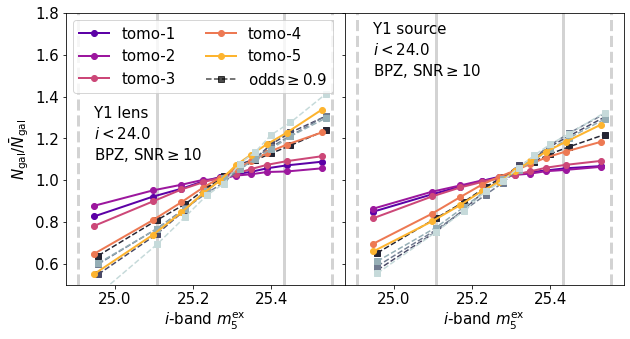

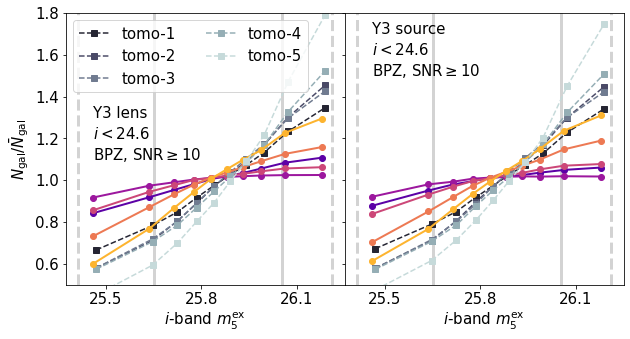

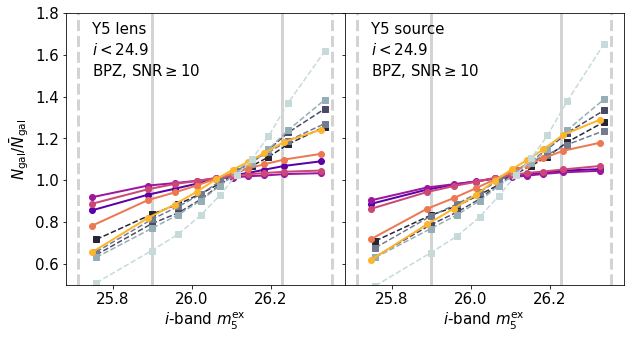

In [17]:
for year in [1,3,5]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)

    # BPZ lens
    stats=[packed_stats_lens[year], packed_stats_source[year]]
    stats_odds=[packed_stats_odds_lens[year], packed_stats_odds_source[year]]

    for ii in range(2):
        plt.sca(axarr[ii])
        
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [0.5,1.8], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [0.5,1.8], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [0.5,1.8], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [0.5,1.8], color='lightgrey',lw=3,ls='--')
        
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            plt.sca(axarr[ii])
            
            N_galaxies=np.zeros(10)
            for q in range(10):
                nz = stats[ii]["tomo-%d"%(kk+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])
            # show
            N_mean=np.sum(N_galaxies*qweights)/np.sum(qweights)
            plt.plot(mean_sys[year], N_galaxies/N_mean, 'o-',fillstyle="full",
                     label=label1[year][kk],color=cmap(colorlab),lw=2)
            
            N_galaxies=np.zeros(10)
            for q in range(10):
                nz = stats_odds[ii]["tomo-%d"%(kk+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])
            # show
            N_mean=np.sum(N_galaxies*qweights)/np.sum(qweights)
            plt.plot(mean_sys[year]+0.01, N_galaxies/N_mean, 's--',fillstyle="full",
                     color=cmap2(colorlab),label=label2[year][kk])
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([0.5,1.8])
        
        if ii==0:
            plt.ylabel("$N_{\\rm gal}/\\bar{N}_{\\rm gal}$")

    plt.subplots_adjust(wspace=0,hspace=0)
    
    if year in [1,3]:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 1.3, f"Y{year} lens")
        plt.text(mean_sys[year][0], 1.2, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 1.1, "BPZ, SNR$\\geq10$")
    else:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 1.7, f"Y{year} lens")
        plt.text(mean_sys[year][0], 1.6, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 1.5, "BPZ, SNR$\\geq10$")

    plt.sca(axarr[1])
    plt.text(mean_sys[year][0], 1.7, f"Y{year} source")
    plt.text(mean_sys[year][0], 1.6, f"$i<{gold_i}$")
    plt.text(mean_sys[year][0], 1.5, "BPZ, SNR$\\geq10$")
    
    if year==1:
        plt.sca(axarr[0])
        plt.plot(mean_sys[year][0], 0.1, 's--',fillstyle="full",
                     color='k',alpha=0.7, label="odds$\\geq 0.9$")
        plt.legend(loc="upper left", ncol=2)
    if year==3:
        plt.sca(axarr[0])
        plt.xticks([25.5,25.8,26.1])
        plt.legend(loc="upper left", ncol=2)
        
    plt.savefig(f"plots/ngal-baselinev3.3-Y{year}-bpz.pdf",bbox_inches="tight")

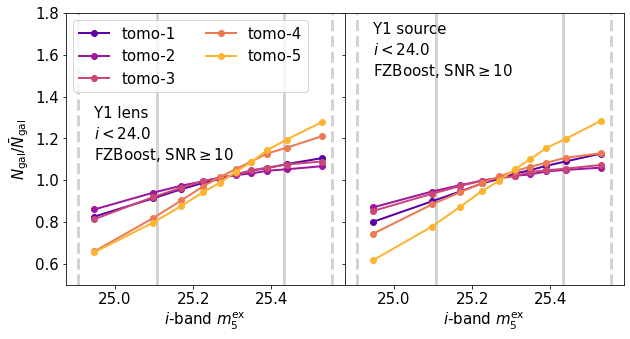

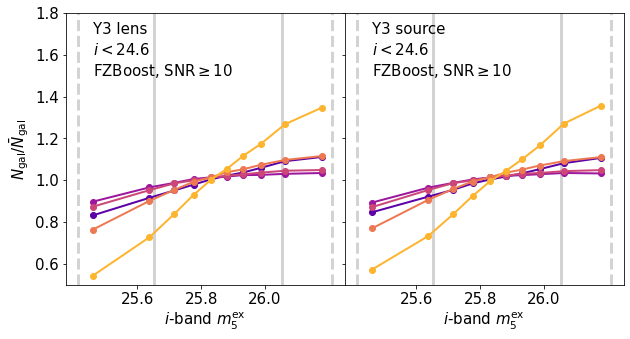

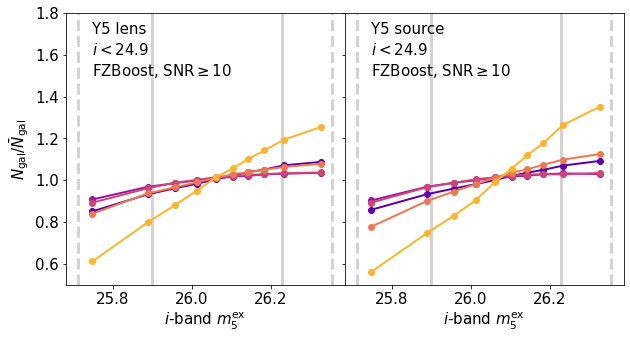

In [18]:
for year in [1,3,5]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)

    # FZB
    stats=[packed_stats_fzb_lens[year], packed_stats_fzb_source[year]]

    for ii in range(2):
        plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [0.5,1.8], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [0.5,1.8], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [0.5,1.8], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [0.5,1.8], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            plt.sca(axarr[ii])
            
            N_galaxies=np.zeros(10)
            for q in range(10):
                nz = stats[ii]["tomo-%d"%(kk+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])
            # show
            N_mean=np.sum(N_galaxies*qweights)/np.sum(qweights)
            plt.plot(mean_sys[year], N_galaxies/N_mean, 'o-',fillstyle="full",
                     label='tomo-%d'%(kk+1),color=cmap(colorlab),lw=2)
            
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([0.5,1.8])
        if ii==0:
            plt.ylabel("$N_{\\rm gal}/\\bar{N}_{\\rm gal}$")

    plt.subplots_adjust(wspace=0,hspace=0)
    
    if year==1:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 1.3, f"Y{year} lens")
        plt.text(mean_sys[year][0], 1.2, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 1.1, "FZBoost, SNR$\\geq10$")
    else:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 1.7, f"Y{year} lens")
        plt.text(mean_sys[year][0], 1.6, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 1.5, "FZBoost, SNR$\\geq10$")

    plt.sca(axarr[1])
    plt.text(mean_sys[year][0], 1.7, f"Y{year} source")
    plt.text(mean_sys[year][0], 1.6, f"$i<{gold_i}$")
    plt.text(mean_sys[year][0], 1.5, "FZBoost, SNR$\\geq10$")
    
    plt.sca(axarr[0])
    if year==1:
        plt.legend(loc="upper left", ncol=2)
    if year==3:
        plt.xticks([25.6,25.8,26.0])
        
    plt.savefig(f"plots/ngal-baselinev3.3-Y{year}-fzb.pdf",bbox_inches="tight")

## delta mean z vs depth

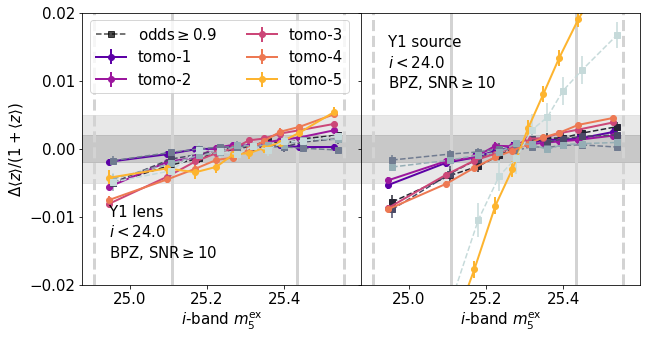

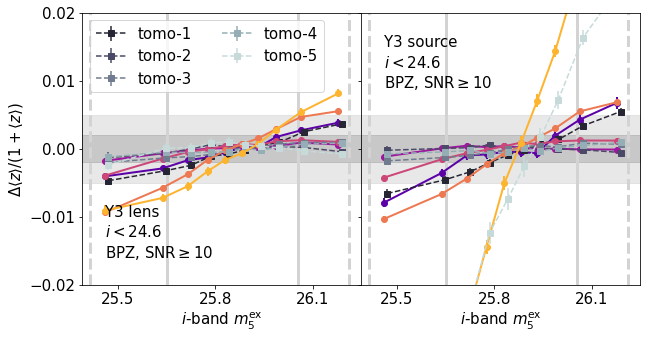

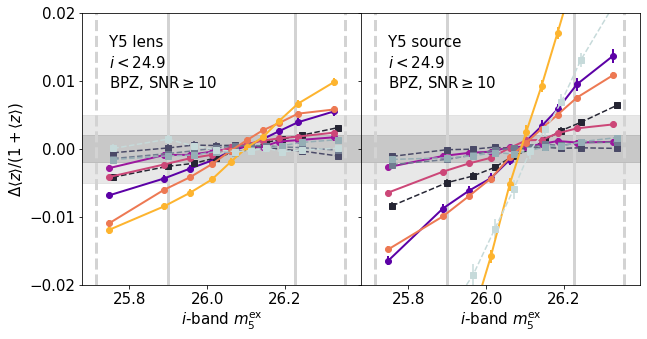

In [19]:
for year in [1,3,5]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)

    # BPZ lens
    stats=[packed_stats_lens[year], packed_stats_source[year]]
    stats_odds=[packed_stats_odds_lens[year], packed_stats_odds_source[year]]

    for ii in range(2):
        plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [-0.02,0.02], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [-0.02,0.02], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [-0.02,0.02], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [-0.02,0.02], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            meanz = stats[ii]["tomo-%d"%(kk+1)]["meanz"]
            meanztot = stats[ii]["tomo-%d"%(kk+1)]["meanztot"]
            plt.errorbar(mean_sys[year], (meanz[:,0]-meanztot)/(1+meanztot), 
                         yerr=meanz[:,1]/(1+meanztot),fmt='o-',
                         color=cmap(colorlab),label=label1[year][kk],lw=2)
    
            # BPZ odds
            meanz = stats_odds[ii]["tomo-%d"%(kk+1)]["meanz"]
            meanztot = stats_odds[ii]["tomo-%d"%(kk+1)]["meanztot"]
            plt.errorbar(mean_sys[year]+0.01, (meanz[:,0]-meanztot)/(1+meanztot), 
                         yerr=meanz[:,1]/(1+meanztot),fmt='s--',
                         fillstyle="full",
                         color=cmap2(colorlab),label=label2[year][kk])

        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([-0.02,0.02])
        if ii==0:
            plt.ylabel("$\\Delta \\langle z\\rangle / (1+\\langle z\\rangle)$")
            plt.yticks([-0.02,-0.01,0,0.01,0.02])
        plt.fill_between([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07],
                        [-0.005,-0.005],[0.005,0.005],color='lightgrey', alpha=0.5)
        plt.fill_between([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07],
                        [-0.002,-0.002],[0.002,0.002],color='grey', alpha=0.3)
        plt.xlim([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07])

    plt.subplots_adjust(wspace=0,hspace=0)
    
    if year in [1,3]:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], -0.01, f"Y{year} lens")
        plt.text(mean_sys[year][0], -0.013, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], -0.016, "BPZ, SNR$\\geq10$")
    else:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 0.015, f"Y{year} lens")
        plt.text(mean_sys[year][0], 0.012, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 0.009, "BPZ, SNR$\\geq10$")

    plt.sca(axarr[1])
    plt.text(mean_sys[year][0], 0.015, f"Y{year} source")
    plt.text(mean_sys[year][0], 0.012, f"$i<{gold_i}$")
    plt.text(mean_sys[year][0], 0.009, "BPZ, SNR$\\geq10$")
    
    
    if year==1:
        plt.sca(axarr[0])
        plt.plot(mean_sys[year][0], 0.1, 's--',fillstyle="full",
                     color='k',alpha=0.7, label="odds$\\geq 0.9$")
        plt.legend(loc="upper left", ncol=2)
    if year==3:
        plt.sca(axarr[0])
        plt.xticks([25.5,25.8,26.1])
        plt.legend(loc="upper left", ncol=2)
        
    plt.savefig(f"plots/meanz-baselinev3.3-Y{year}-bpz.pdf",bbox_inches="tight")

In [53]:
# print all meanz from lens, source, different photo-z type etc.:
for year in [1,3,5]:
    
    print(f"Year {year}")
    
    # BPZ lens
    stats_lens=[packed_stats_lens[year], packed_stats_odds_lens[year]]
    stats_source=[packed_stats_source[year], packed_stats_odds_source[year]]
    
    phrase1 = "lens: "
    phrase2 = "source: "
    for ii in range(2):
        for kk in range(5):
            stat1 = round(stats_lens[ii]["tomo-%d"%(kk+1)]["meanztot"],3)
            stat2 = round(stats_source[ii]["tomo-%d"%(kk+1)]["meanztot"],3)
            phrase1 += f" & ${stat1}$"
            phrase2 += f" & ${stat2}$"
    print(phrase1)
    print(phrase2)

Year 1
lens:  & $0.362$ & $0.537$ & $0.714$ & $0.882$ & $1.05$ & $0.337$ & $0.549$ & $0.716$ & $0.89$ & $1.056$
source:  & $0.35$ & $0.482$ & $0.661$ & $0.813$ & $0.883$ & $0.31$ & $0.508$ & $0.678$ & $0.817$ & $0.845$
Year 3
lens:  & $0.373$ & $0.541$ & $0.728$ & $0.912$ & $1.067$ & $0.345$ & $0.55$ & $0.721$ & $0.895$ & $1.064$
source:  & $0.384$ & $0.557$ & $0.755$ & $0.954$ & $1.033$ & $0.332$ & $0.577$ & $0.726$ & $0.866$ & $0.973$
Year 5
lens:  & $0.383$ & $0.545$ & $0.736$ & $0.931$ & $1.085$ & $0.348$ & $0.549$ & $0.723$ & $0.898$ & $1.064$
source:  & $0.417$ & $0.594$ & $0.804$ & $1.028$ & $1.15$ & $0.345$ & $0.599$ & $0.751$ & $0.904$ & $1.019$


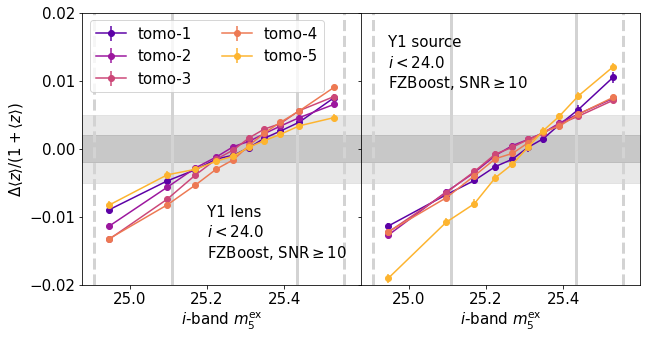

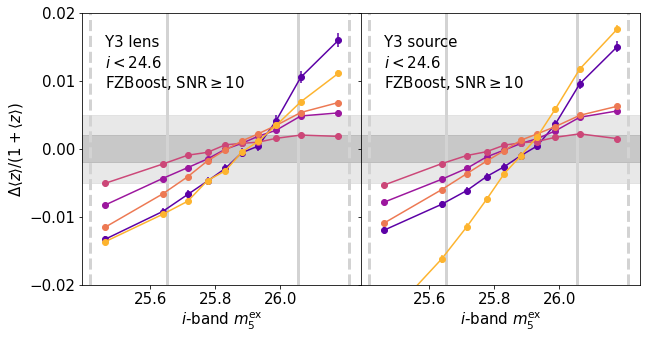

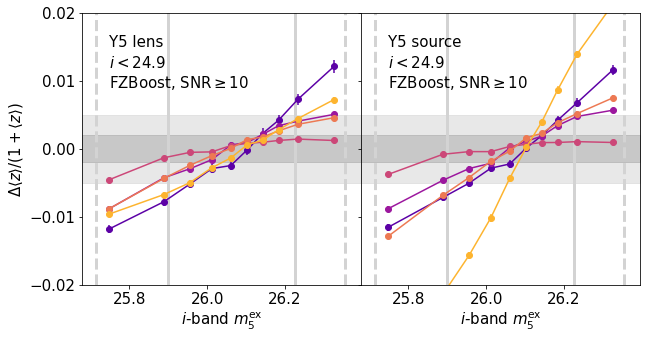

In [20]:
for year in [1,3,5]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)

    # FZB lens
    stats=[packed_stats_fzb_lens[year], packed_stats_fzb_source[year]]

    for ii in range(2):
        plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [-0.02,0.02], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [-0.02,0.02], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [-0.02,0.02], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [-0.02,0.02], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            meanz = stats[ii]["tomo-%d"%(kk+1)]["meanz"]
            meanztot = stats[ii]["tomo-%d"%(kk+1)]["meanztot"]
            plt.errorbar(mean_sys[year], (meanz[:,0]-meanztot)/(1+meanztot), 
                         yerr=meanz[:,1]/(1+meanztot),fmt='o-',
                         color=cmap(colorlab),label='tomo-%d'%(kk+1))
    
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([-0.02,0.02])
        if ii==0:
            plt.ylabel("$\\Delta \\langle z\\rangle / (1+\\langle z\\rangle)$")
            plt.yticks([-0.02,-0.01,0,0.01,0.02])
        plt.fill_between([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07],
                        [-0.005,-0.005],[0.005,0.005],color='lightgrey', alpha=0.5)
        plt.fill_between([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07],
                        [-0.002,-0.002],[0.002,0.002],color='grey', alpha=0.3)
        plt.xlim([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07])

    plt.subplots_adjust(wspace=0,hspace=0)
    
    if year==1:
        plt.sca(axarr[0])
        plt.text(25.2, -0.01, f"Y{year} lens")
        plt.text(25.2, -0.013, f"$i<{gold_i}$")
        plt.text(25.2, -0.016, "FZBoost, SNR$\\geq10$")
    else:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 0.015, f"Y{year} lens")
        plt.text(mean_sys[year][0], 0.012, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 0.009, "FZBoost, SNR$\\geq10$")

    plt.sca(axarr[1])
    plt.text(mean_sys[year][0], 0.015, f"Y{year} source")
    plt.text(mean_sys[year][0], 0.012, f"$i<{gold_i}$")
    plt.text(mean_sys[year][0], 0.009, "FZBoost, SNR$\\geq10$")
    
    plt.sca(axarr[0])
    if year==1:
        plt.legend(loc="upper left", ncol=2)
    if year==3:
        plt.xticks([25.6,25.8,26.0])
        
    plt.savefig(f"plots/meanz-baselinev3.3-Y{year}-fzb.pdf",bbox_inches="tight")

In [54]:
for year in [1,3,5]:
    
    print(f"Year {year}")
    
    # fzb lens
    stats_lens=[packed_stats_fzb_lens[year]]
    stats_source=[packed_stats_fzb_source[year]]
    
    phrase1 = "lens: "
    phrase2 = "source: "
    for ii in range(1):
        for kk in range(5):
            stat1 = round(stats_lens[ii]["tomo-%d"%(kk+1)]["meanztot"],3)
            stat2 = round(stats_source[ii]["tomo-%d"%(kk+1)]["meanztot"],3)
            phrase1 += f" & ${stat1}$"
            phrase2 += f" & ${stat2}$"
    print(phrase1)
    print(phrase2)

Year 1
lens:  & $0.327$ & $0.515$ & $0.706$ & $0.865$ & $1.083$
source:  & $0.291$ & $0.466$ & $0.623$ & $0.779$ & $1.03$
Year 3
lens:  & $0.32$ & $0.5$ & $0.702$ & $0.894$ & $1.093$
source:  & $0.328$ & $0.531$ & $0.718$ & $0.893$ & $1.213$
Year 5
lens:  & $0.339$ & $0.51$ & $0.709$ & $0.905$ & $1.104$
source:  & $0.35$ & $0.567$ & $0.764$ & $0.971$ & $1.342$


## width vs depth for lens

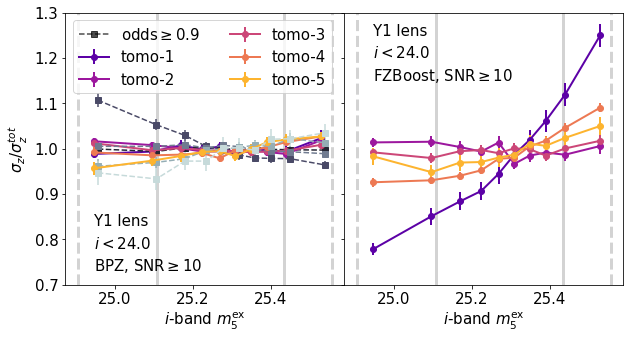

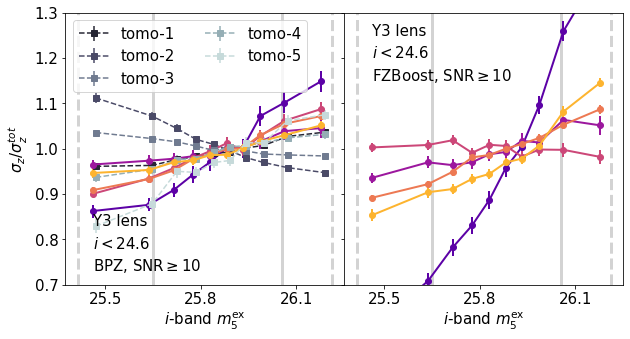

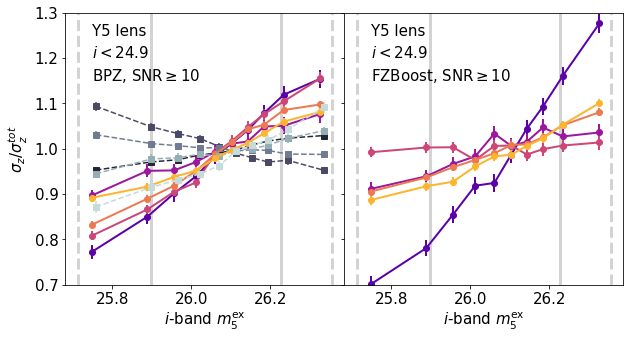

In [21]:
for year in [1,3,5]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)

    # FZB lens
    stats=[packed_stats_lens[year], packed_stats_fzb_lens[year]]
    stats2 = packed_stats_odds_lens[year]

    for ii in range(2):
        plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            sigmaz = stats[ii]["tomo-%d"%(kk+1)]["sigmaz"]
            sigmaztot = stats[ii]["tomo-%d"%(kk+1)]["sigmaztot"]
            plt.errorbar(mean_sys[year], sigmaz[:,0]/sigmaztot, yerr=sigmaz[:,1]/sigmaztot,
                         fmt='o-',color=cmap(colorlab),label=label1[year][kk],lw=2)
            
            if ii==0:
                # BPZ
                sigmaz = stats2["tomo-%d"%(kk+1)]["sigmaz"]
                sigmaztot = stats2["tomo-%d"%(kk+1)]["sigmaztot"]
                plt.errorbar(mean_sys[year]+0.01, sigmaz[:,0]/sigmaztot, yerr=sigmaz[:,1]/sigmaztot,
                             fmt='s--',fillstyle='full',
                             color=cmap2(colorlab),label=label2[year][kk])
    
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([0.7,1.3])
        if ii==0:
            plt.ylabel("$\\sigma_z/\\sigma_z^{tot}$")
        #    plt.yticks([-0.02,-0.01,0,0.01,0.02])
        #plt.xlim([mean_sys[year][0]-0.05, mean_sys[year][-1]+0.05])

    plt.subplots_adjust(wspace=0,hspace=0)
    
    if year in [1,3]:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 0.83, f"Y{year} lens")
        plt.text(mean_sys[year][0], 0.78, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 0.73, "BPZ, SNR$\\geq10$")
    else:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 1.25, f"Y{year} lens")
        plt.text(mean_sys[year][0], 1.2, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 1.15, "BPZ, SNR$\\geq10$")

    plt.sca(axarr[1])
    plt.text(mean_sys[year][0], 1.25, f"Y{year} lens")
    plt.text(mean_sys[year][0], 1.2, f"$i<{gold_i}$")
    plt.text(mean_sys[year][0], 1.15, "FZBoost, SNR$\\geq10$")
    
    if year==1:
        plt.sca(axarr[0])
        plt.plot(mean_sys[year][0], 0.1, 's--',fillstyle="full",
                     color='k',alpha=0.7, label="odds$\\geq 0.9$")
        plt.legend(loc="upper left", ncol=2)
    if year==3:
        plt.sca(axarr[0])
        plt.xticks([25.5,25.8,26.1])
        plt.legend(loc="upper left", ncol=2)
        
    plt.savefig(f"plots/sigmaz-baselinev3.3-Y{year}-bpz-fzb.pdf",bbox_inches="tight")

In [23]:
# print all meanz from lens, source, different photo-z type etc.:
for year in [1,3,5]:
    
    print(f"Year {year}")

    stats=[packed_stats_lens[year], packed_stats_odds_lens[year]]
    
    print("bpz: ")
    phrase=""
    for ii in range(2):
        for kk in range(5):
            stat = round(stats[ii]["tomo-%d"%(kk+1)]["sigmaztot"],3)
            phrase += f" & ${stat}$"
    print(phrase)

print("\\")
    
for year in [1,3,5]:
    print(f"Year {year}")
    stats2 = [packed_stats_fzb_lens[year]]
    
    print("fzb: ")
    for ii in range(1):
        phrase=""
        for kk in range(5):
            stat = round(stats2[ii]["tomo-%d"%(kk+1)]["sigmaztot"],3)
            phrase += f" & ${stat}$"
    print(phrase)

Year 1
bpz: 
 & $0.098$ & $0.123$ & $0.11$ & $0.145$ & $0.172$ & $0.068$ & $0.098$ & $0.087$ & $0.089$ & $0.083$
Year 3
bpz: 
 & $0.123$ & $0.135$ & $0.127$ & $0.166$ & $0.185$ & $0.069$ & $0.093$ & $0.084$ & $0.098$ & $0.103$
Year 5
bpz: 
 & $0.156$ & $0.151$ & $0.16$ & $0.198$ & $0.208$ & $0.071$ & $0.09$ & $0.083$ & $0.102$ & $0.111$
\
Year 1
fzb: 
 & $0.119$ & $0.103$ & $0.114$ & $0.118$ & $0.108$
Year 3
fzb: 
 & $0.183$ & $0.116$ & $0.118$ & $0.135$ & $0.144$
Year 5
fzb: 
 & $0.194$ & $0.136$ & $0.122$ & $0.146$ & $0.142$


In [22]:
# load the nzsq files here:

nzsq={}
nzsq_odds={}
nzsq_fzb={}

for year in [1,3,5]:
    savedir = f"/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y{year}/"
    fname=savedir + f"bpz/test-pz-with-i-band-coadd-Y{year}-snr-10.0-lens-meanApsf-theta_eff-nzsq.pkl"
    nzsq[year]=svf.dump_load(fname)
    
    fname=savedir + f"bpz/test-pz-with-i-band-coadd-Y{year}-snr-10.0-odds-0.9-lens-meanApsf-theta_eff-nzsq.pkl"
    nzsq_odds[year]=svf.dump_load(fname)
    
    fname=savedir + f"fzb/test-pz-with-i-band-coadd-Y{year}-snr-10.0-lens-meanApsf-theta_eff-nzsq.pkl"
    nzsq_fzb[year]=svf.dump_load(fname)
    
#year=1
#savedir = f"/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y{year}/"
#fname=savedir + f"fzb/old_model/test-pz-with-i-band-coadd-Y{year}-snr-10.0-lens-meanApsf-nzsq.pkl"
#nzsq_fzb[year]=svf.dump_load(fname)

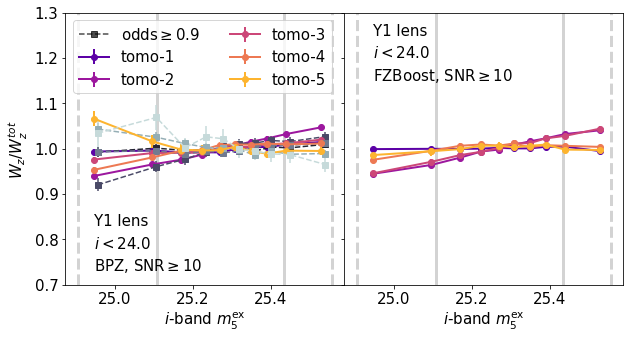

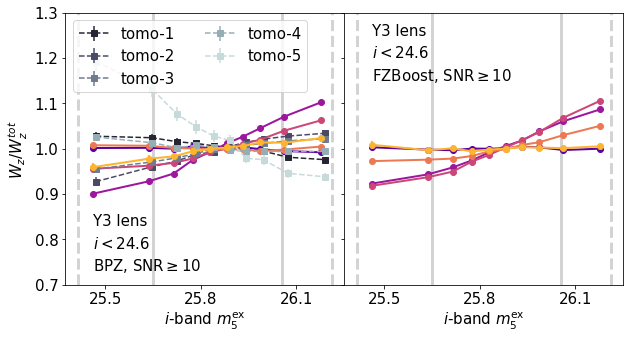

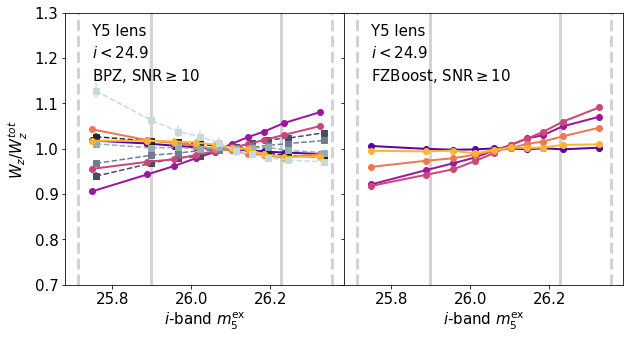

In [23]:
for year in [1,3,5]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)

    # FZB lens
    stats=[nzsq[year], nzsq_fzb[year]]
    stats2 = nzsq_odds[year]

    for ii in range(2):
        plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            nzsqsplit=np.zeros((nquantiles,2))
            for q in range(nquantiles):
                nzsqsplit[q,:] = stats[ii][0]["q%d"%q]["tomo-%d"%(kk+1)][1]
            nzsqtot = stats[ii][1]["tomo-%d"%(kk+1)]
            plt.errorbar(mean_sys[year], nzsqsplit[:,0]/nzsqtot[0], yerr=nzsqsplit[:,1]/nzsqtot[0],
                         fmt='o-',color=cmap(colorlab),label=label1[year][kk],lw=2)
            
            if ii==0:
                nzsqsplit=np.zeros((nquantiles,2))
                for q in range(nquantiles):
                    nzsqsplit[q,:] = stats2[0]["q%d"%q]["tomo-%d"%(kk+1)][1]
                nzsqtot = stats2[1]["tomo-%d"%(kk+1)]
                plt.errorbar(mean_sys[year]+0.01, nzsqsplit[:,0]/nzsqtot[0], yerr=nzsqsplit[:,1]/nzsqtot[0],
                             fmt='s--',fillstyle='full',color=cmap2(colorlab),label=label2[year][kk])
    
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([0.7,1.3])
        if ii==0:
            plt.ylabel("$W_z/W_z^{tot}$")
        #    plt.yticks([-0.02,-0.01,0,0.01,0.02])
        #plt.xlim([mean_sys[year][0]-0.05, mean_sys[year][-1]+0.05])

    plt.subplots_adjust(wspace=0,hspace=0)
    
    if year in [1,3]:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 0.83, f"Y{year} lens")
        plt.text(mean_sys[year][0], 0.78, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 0.73, "BPZ, SNR$\\geq10$")
    else:
        plt.sca(axarr[0])
        plt.text(mean_sys[year][0], 1.25, f"Y{year} lens")
        plt.text(mean_sys[year][0], 1.2, f"$i<{gold_i}$")
        plt.text(mean_sys[year][0], 1.15, "BPZ, SNR$\\geq10$")

    plt.sca(axarr[1])
    plt.text(mean_sys[year][0], 1.25, f"Y{year} lens")
    plt.text(mean_sys[year][0], 1.2, f"$i<{gold_i}$")
    plt.text(mean_sys[year][0], 1.15, "FZBoost, SNR$\\geq10$")
    
    
    if year==1:
        plt.sca(axarr[0])
        plt.plot(mean_sys[year][0], 0.1, 's--',fillstyle="full",
                     color='k',alpha=0.7, label="odds$\\geq 0.9$")
        plt.legend(loc="upper left", ncol=2)
    if year==3:
        plt.sca(axarr[0])
        plt.xticks([25.5,25.8,26.1])
        plt.legend(loc="upper left", ncol=2)
        
    plt.savefig(f"plots/wz-baselinev3.3-Y{year}-bpz-fzb.pdf",bbox_inches="tight")

In [58]:
# print all meanz from lens, source, different photo-z type etc.:
for year in [1,3,5]:
    
    print(f"Year {year}")
    
    # BPZ lens
    stats=[nzsq[year], nzsq_fzb[year]]
    
    phrase="bpz: "
    for ii in range(2):
        for kk in range(5):
            stat = round(stats[ii][1]["tomo-%d"%(kk+1)][0],3)
            phrase += f" & ${stat}$"
    print(phrase)
        
        
for year in [1,3,5]:
    
    print(f"Year {year}")

    stats=[nzsq_odds[year]]
    
    phrase="fzb: "
    for ii in range(1):
        for kk in range(5):
            stat = round(stats[ii][1]["tomo-%d"%(kk+1)][0],3)
            phrase += f" & ${stat}$"
    print(phrase)

Year 1
bpz:  & $3.216$ & $2.797$ & $2.785$ & $2.535$ & $1.945$ & $3.453$ & $3.453$ & $3.311$ & $2.919$ & $3.062$
Year 3
bpz:  & $3.208$ & $3.123$ & $2.872$ & $2.514$ & $2.147$ & $3.602$ & $3.517$ & $3.361$ & $2.977$ & $2.952$
Year 5
bpz:  & $3.136$ & $3.267$ & $2.894$ & $2.394$ & $2.087$ & $3.92$ & $3.683$ & $3.423$ & $2.945$ & $2.982$
Year 1
fzb:  & $4.236$ & $3.098$ & $3.202$ & $3.242$ & $3.719$
Year 3
fzb:  & $4.22$ & $3.263$ & $3.385$ & $3.061$ & $3.053$
Year 5
fzb:  & $4.15$ & $3.332$ & $3.428$ & $3.037$ & $2.908$


# Y3 fzb lens maglim case:

In [9]:
root = '/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/'
packed_stats_maglim = {}
for year in [3]:
    fname=root+f'y{year}/fzb/test-pz-with-i-band-coadd-Y{year}-snr-5.0-lens-meanApsf-theta_eff-maglim.yml'
    with open(fname, "r") as stream:
        packed_stats_maglim[year]=yaml.load(stream,Loader=yaml.Loader)

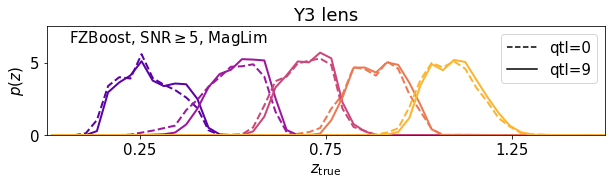

In [23]:
for year in [3]:
    #fig,axarr=plt.subplots(3,2, figsize=[20,6],sharex=True, sharey=True)
    plt.figure(figsize=[10,2])
    
    #fig.suptitle(f"Year {year}")
    stats=[packed_stats_maglim[year]]
    
    title=[f"Y{year} lens"]
    text=["FZBoost, SNR$\\geq 5$, MagLim"]
    
    for ii in range(1):
        for jj in range(1):
            #plt.sca(axarr[ii,jj])
            mm = ii*2+jj
            for kk in range(5):
                colorlab=(kk+1)/(5*1.2)
                
                # total case
                #nz = stats["tomo-%d"%(kk+1)]["nztot"]
                #y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                #plt.fill_between(nz[:,0], 0, y, color=cmap(colorlab),alpha=0.3, label='Full')

                # qtl 0 and 9
                nz = stats[mm]["tomo-%d"%(kk+1)]["nz"][0]
                y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                plt.plot(nz[:,0], y, color=cmap(colorlab),lw=2, ls="--")

                nz = stats[mm]["tomo-%d"%(kk+1)]["nz"][9]
                y=nz[:,1]/np.sum(nz[:,1])/(nz[1,0]-nz[0,0])
                plt.plot(nz[:,0], y, color=cmap(colorlab),lw=2)
            plt.xlim([0,1.5])
            plt.ylim([0,7.5])
            plt.xticks([0.25,0.75,1.25])
            if ii==0:
                plt.title(title[jj])
            if jj==0:
                plt.ylabel("$p(z)$")
            if ii==0:
                plt.xlabel("$z_{\\rm true}$")
            plt.text(0.06,6.4,text[mm])
            plt.yticks([0,5])
    
    #plt.sca(axarr[0,1])
    plt.plot([0],[0],'k--',label="qtl=0")
    plt.plot([0],[0],'k-',label="qtl=9")
    plt.legend()
    plt.subplots_adjust(hspace=0, wspace=0)
    
    plt.savefig(f"plots/nz-baselinev3.3-y{year}-long-maglim.pdf",bbox_inches="tight")

In [33]:
for year in [3]:

    stats=[packed_stats_maglim[year]]
    names=["fzb lens maglim"]
    
    print(f"Year {year}")
    print(names[:1])
    
    phrase=""
    for ss, nn in zip(stats[:1],names[:1]):
        N_lens=[]
        # number of objects as a function of depth:
        for ii in range(5):
            colorlab = (ii+1)/(5*1.2)
            N_galaxies=np.zeros(10)

            for q in range(10):
                nz = ss["tomo-%d"%(ii+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])#/totpix
            N_lens.append(N_galaxies)
        # print total number of lens weighted by pixels
        N_totlens=0
        #N_tot_zbin_list=[]
        
        for ii in range(5):
            N_tot_zbin=np.sum(N_lens[ii]*qweights)
            N_totlens+=N_tot_zbin
            #N_tot_zbin_list.append(round(N_tot_zbin,1))
            phrase += f" & ${round(N_tot_zbin,1)}$"
            
    print(phrase)

Year 3
['fzb lens maglim']
 & $1216.8$ & $1047.2$ & $1405.4$ & $1970.6$ & $2394.7$


In [38]:
ngal_maglim = 1216.8+ 1047.2 + 1405.4 + 1970.6 + 2394.7
print(ngal_maglim)

ngal_goldlens =  34498.5 + 52662.6 + 51564.7 + 52858.0 + 27561.2
print(ngal_goldlens)

frac = ngal_maglim / ngal_goldlens
print(frac)

# now compute the number density for each bin:
x = np.array([1216.8,1047.2,1405.4,1970.6,2394.7])
# 24.4 is the n gal / arcmin^2 used for lens 
print(x/ngal_maglim*24.4*frac)

8034.7
219145.0
0.036663852700266945
[0.13548071 0.11659714 0.15647977 0.21941016 0.26663022]


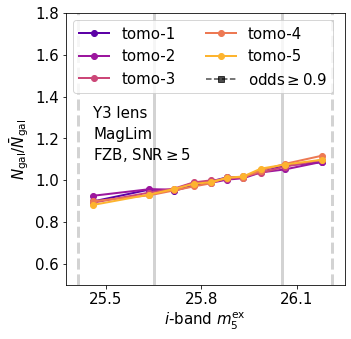

In [24]:
for year in [3]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    #fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)
    plt.figure(figsize=[5,5])

    stats=[packed_stats_maglim[year]]
    #stats_odds=[packed_stats_odds_lens[year], packed_stats_odds_source[year]]

    for ii in range(1):
        #plt.sca(axarr[ii])
        
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [0.5,1.8], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [0.5,1.8], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [0.5,1.8], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [0.5,1.8], color='lightgrey',lw=3,ls='--')
        
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            #plt.sca(axarr[ii])
            
            N_galaxies=np.zeros(10)
            for q in range(10):
                nz = stats[ii]["tomo-%d"%(kk+1)]["nz"][q]
                N_galaxies[q]=np.sum(nz[:,1])
            # show
            N_mean=np.sum(N_galaxies*qweights)/np.sum(qweights)
            plt.plot(mean_sys[year], N_galaxies/N_mean, 'o-',fillstyle="full",
                     label=label2[year][kk],color=cmap(colorlab),lw=2)
            
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([0.5,1.8])
        
        if ii==0:
            plt.ylabel("$N_{\\rm gal}/\\bar{N}_{\\rm gal}$")

    plt.subplots_adjust(wspace=0,hspace=0)
    

    plt.text(mean_sys[year][0], 1.3, f"Y{year} lens")
    plt.text(mean_sys[year][0], 1.2, "MagLim")
    plt.text(mean_sys[year][0], 1.1, "FZB, SNR$\\geq5$")
    

    #plt.sca(axarr[0])
    plt.plot(mean_sys[year][0], 0.1, 's--',fillstyle="full",
                 color='k',alpha=0.7, label="odds$\\geq 0.9$")
    plt.legend(loc="upper left", ncol=2)

    #plt.sca(axarr[0])
    plt.xticks([25.5,25.8,26.1])
    plt.legend(loc="upper left", ncol=2)
        
    plt.savefig(f"plots/ngal-baselinev3.3-Y{year}-fzb-maglim.pdf",bbox_inches="tight")

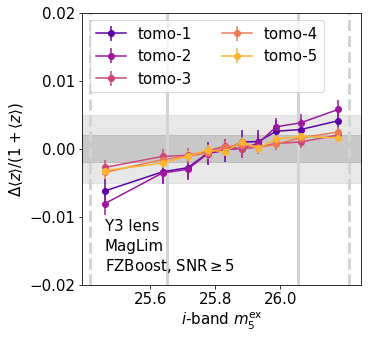

In [25]:
for year in [3]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    #fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)
    plt.figure(figsize=[5,5])

    stats=[packed_stats_maglim[year]]

    for ii in range(1):
        #plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [-0.02,0.02], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [-0.02,0.02], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [-0.02,0.02], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [-0.02,0.02], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            meanz = stats[ii]["tomo-%d"%(kk+1)]["meanz"]
            meanztot = stats[ii]["tomo-%d"%(kk+1)]["meanztot"]
            plt.errorbar(mean_sys[year], (meanz[:,0]-meanztot)/(1+meanztot), 
                         yerr=meanz[:,1]/(1+meanztot),fmt='o-',
                         color=cmap(colorlab),label='tomo-%d'%(kk+1))
    
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([-0.02,0.02])
        if ii==0:
            plt.ylabel("$\\Delta \\langle z\\rangle / (1+\\langle z\\rangle)$")
            plt.yticks([-0.02,-0.01,0,0.01,0.02])
        plt.fill_between([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07],
                        [-0.005,-0.005],[0.005,0.005],color='lightgrey', alpha=0.5)
        plt.fill_between([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07],
                        [-0.002,-0.002],[0.002,0.002],color='grey', alpha=0.3)
        plt.xlim([mean_sys[year][0]-0.07, mean_sys[year][-1]+0.07])

    plt.subplots_adjust(wspace=0,hspace=0)
    
    plt.text(mean_sys[year][0], -0.012, f"Y{year} lens")
    plt.text(mean_sys[year][0], -0.015, "MagLim")
    plt.text(mean_sys[year][0], -0.018, "FZBoost, SNR$\\geq5$")

    #plt.sca(axarr[0])
    plt.legend(loc="upper left", ncol=2)
    plt.xticks([25.6,25.8,26.0])
    
    plt.savefig(f"plots/meanz-baselinev3.3-Y{year}-fzb-maglim.pdf",bbox_inches="tight")

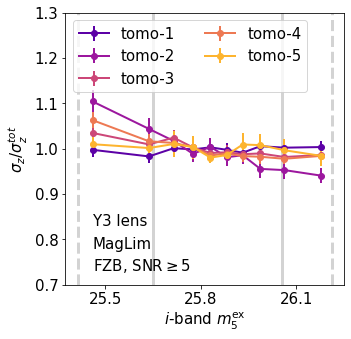

In [26]:
for year in [3]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    #fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)
    plt.figure(figsize=[5,5])

    stats=[packed_stats_maglim[year]]
    
    for ii in range(1):
        #plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            sigmaz = stats[ii]["tomo-%d"%(kk+1)]["sigmaz"]
            sigmaztot = stats[ii]["tomo-%d"%(kk+1)]["sigmaztot"]
            plt.errorbar(mean_sys[year], sigmaz[:,0]/sigmaztot, yerr=sigmaz[:,1]/sigmaztot,
                         fmt='o-',color=cmap(colorlab),label=label2[year][kk],lw=2)
    
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([0.7,1.3])
        if ii==0:
            plt.ylabel("$\\sigma_z/\\sigma_z^{tot}$")
        #    plt.yticks([-0.02,-0.01,0,0.01,0.02])
        #plt.xlim([mean_sys[year][0]-0.05, mean_sys[year][-1]+0.05])

    #plt.subplots_adjust(wspace=0,hspace=0)
    

    plt.text(mean_sys[year][0], 0.83, f"Y{year} lens")
    plt.text(mean_sys[year][0], 0.78, "MagLim")
    plt.text(mean_sys[year][0], 0.73, "FZB, SNR$\\geq5$")
    
    plt.xticks([25.5,25.8,26.1])
    plt.legend(loc="upper left", ncol=2)
    plt.savefig(f"plots/sigmaz-baselinev3.3-Y{year}-fzb-maglim.pdf",bbox_inches="tight")

In [14]:
nzsq_maglim={}

for year in [3]:
    savedir = f"/pscratch/sd/q/qhang/roman-rubin-sims/baselinev3.3/y{year}/"
    fname=savedir + f"fzb/test-pz-with-i-band-coadd-Y{year}-snr-5.0-lens-meanApsf-theta_eff-maglim-nzsq.pkl"
    nzsq_maglim[year]=svf.dump_load(fname)

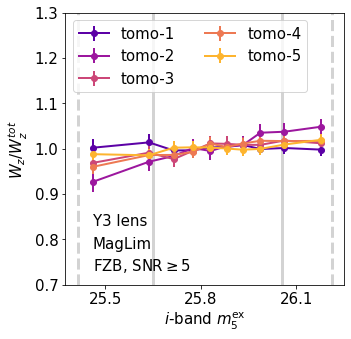

In [27]:
for year in [3]:
    gold_i = gold_i_10yr - 2.5*np.log10(np.sqrt(10/year))
    gold_i = round(gold_i,1)
    #fig,axarr=plt.subplots(1,2,figsize=[10,5],sharex=True,sharey=True)
    plt.figure(figsize=[5,5])

    stats=[nzsq_maglim[year]]
    
    for ii in range(1):
        #plt.sca(axarr[ii])
        # plot 1 and 2 sigma range:
        plt.plot([one_sig_depth[year][0], one_sig_depth[year][0]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([one_sig_depth[year][1], one_sig_depth[year][1]], [0.7,1.3], color='lightgrey', lw=3)
        plt.plot([two_sig_depth[year][0], two_sig_depth[year][0]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        plt.plot([two_sig_depth[year][1], two_sig_depth[year][1]], [0.7,1.3], color='lightgrey',lw=3,ls='--')
        for kk in range(5):
            colorlab = (kk+1)/(5*1.2)
            # BPZ
            nzsqsplit=np.zeros((nquantiles,2))
            for q in range(nquantiles):
                nzsqsplit[q,:] = stats[ii][0]["q%d"%q]["tomo-%d"%(kk+1)][1]
            nzsqtot = stats[ii][1]["tomo-%d"%(kk+1)]
            plt.errorbar(mean_sys[year], nzsqsplit[:,0]/nzsqtot[0], yerr=nzsqsplit[:,1]/nzsqtot[0],
                         fmt='o-',color=cmap(colorlab),label=label2[year][kk],lw=2)
    
        plt.xlabel("$i$-band $m_5^{\\rm ex}$")
        plt.ylim([0.7,1.3])
        if ii==0:
            plt.ylabel("$W_z/W_z^{tot}$")
        #    plt.yticks([-0.02,-0.01,0,0.01,0.02])
        #plt.xlim([mean_sys[year][0]-0.05, mean_sys[year][-1]+0.05])

    #plt.subplots_adjust(wspace=0,hspace=0)
    

    plt.text(mean_sys[year][0], 0.83, f"Y{year} lens")
    plt.text(mean_sys[year][0], 0.78, "MagLim")
    plt.text(mean_sys[year][0], 0.73, "FZB, SNR$\\geq5$")

    plt.xticks([25.5,25.8,26.1])
    plt.legend(loc="upper left", ncol=2)
    
    plt.savefig(f"plots/wz-baselinev3.3-Y{year}-fzb-maglim.pdf",bbox_inches="tight")

# Clgg for Maglim:

In [16]:
ellmax=[265.9807349941148, 403.1155966170281, 539.8220627877016, 653.0018484000559, 756.7049307487994]
pshot = np.array([6.451400144212375e-07, 7.381277724137032e-07, 5.58668132340528e-07, 
                  3.943298655590948e-07, 3.249200879550556e-07])
nside=512
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2

In [17]:
root="/pscratch/sd/q/qhang/dirac_mock/desc-project285/"
ell=np.loadtxt(root+"effective_ells.txt")
bw=np.load(root+"wb-clgg-binning-20-2000-nell-20-log.npy")

In [18]:
def convolve_bandpower(bw, cl_th):
    # convolve with band power:
    usebw=bw[0,:,0,:]
    L=len(cl_th)
    L2=usebw.shape[1]
    if L2>=L: 
        cl_th_binned=np.dot(cl_th, usebw[:,:L].T)
    else:
        cl_th_binned=np.dot(cl_th[:L2], usebw.T)
    return cl_th_binned

In [19]:
clgg_binned_un = np.loadtxt(root+"data-nmt-clgg-maglim-512-binning-20-2000.txt")
clgg_binned_vd = np.loadtxt(root+"data-nmt-clgg-vd-maglim-512-binning-20-2000.txt")

# covmat
clgg_cov = {}
for ii in range(5):
    fname = root+f"cov-nmt-clgg-maglim-tomo-{ii}-512-binning-20-2000.txt"
    clgg_cov[ii]=np.loadtxt(fname)
    
# theory - binned:
clgg_theory = np.loadtxt(root+"clgg-maglim-theory-z_bin-nside-512.txt")
# add pixwin and shotnoise
pshot = np.array([6.451400144212375e-07, 7.381277724137032e-07, 5.58668132340528e-07, 
                  3.943298655590948e-07, 3.249200879550556e-07])
pixwin=hp.pixwin(nside,lmax=3*nside-1)**2
clgg_theory_binned = []
for ii in range(5):
    tmp=(clgg_theory[:,ii]*pixwin)+pshot[ii]
    # binned version:
    clgg_theory_binned.append(convolve_bandpower(bw, tmp))

In [20]:
chi2_un = [0.83808058, 1.27341863, 2.23674703, 1.97885803, 1.20546043]
chi2_vd = [1.76319215,  2.24202239,  6.92250783, 21.21629712, 32.52148546]

In [21]:
fsky=0.41963705

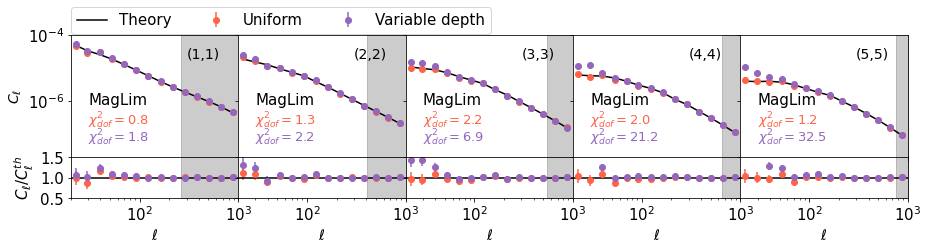

In [22]:
# plot auto-correlations:
fig,axarr=plt.subplots(2,5,figsize=[15,3],sharey="row",sharex=True, 
                       gridspec_kw={'height_ratios': [3, 1]})

for ii in range(5):
    plt.sca(axarr[0,ii])
    plt.yscale("log")
    b1=b2=f"lens_{ii}"
    
    plt.text(300,2e-5,f"({ii+1},{ii+1})",fontsize=14)
    
    yerr=np.sqrt(np.diag(clgg_cov[ii])/fsky)
    plt.errorbar(ell, clgg_binned_un[ii,:]-pshot[ii], yerr=yerr, fmt='o', color="tomato",
                 label='Uniform')
    plt.errorbar(ell, clgg_binned_vd[ii,:]-pshot[ii], yerr=yerr, fmt='o',color="tab:purple",
                 label='Variable depth')
    plt.plot(ell, clgg_theory_binned[ii]-pshot[ii], 'k-',label='Theory')
    
    plt.fill_between([ellmax[ii],1000],[1e-8,1e-8],[1e-4,1e-4],alpha=0.2,color="k")
    plt.ylim([2e-8,1e-4])
    plt.xlim([20,1000])
    chi2txt = "\\chi^2_{dof}"
    plt.text(30,2e-7,f"${chi2txt}={round(chi2_un[ii],1)}$",color="tomato",fontsize=13)
    plt.text(30,6e-8,f"${chi2txt}={round(chi2_vd[ii],1)}$",color="tab:purple",fontsize=13)
    plt.text(30,8e-7, "MagLim")

    if ii==0:
        plt.legend(ncol=3, loc=[0,1.01])
        plt.ylabel('$C_\\ell$',fontsize=14)

    #plt.ylim([0,2e-5])
    plt.sca(axarr[1,ii])
    plt.xscale("log")
    if ii==0:
        plt.ylabel("$C_\\ell/C^{th}_\\ell$")
        plt.yticks([0.5,1.0,1.5])
        
    plt.errorbar(ell, clgg_binned_un[ii,:]/clgg_theory_binned[ii], 
                 yerr=yerr/clgg_theory_binned[ii], fmt='o', color="tomato",
                 label='Uniform')
    plt.errorbar(ell, clgg_binned_vd[ii,:]/clgg_theory_binned[ii], 
                 yerr=yerr/clgg_theory_binned[ii], fmt='o', color="tab:purple",
                 label='VD')
    
    plt.fill_between([ellmax[ii],1000],[0.5,0.5],[1.5,1.5],alpha=0.2,color="k")
    plt.xlim([20,1000])
    plt.ylim([0.5,1.5])
    plt.xlabel('$\\ell$',fontsize=14)
    plt.plot([20,1000],[1,1],'k-')

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig("plots/clgg-y3-fzb-maglim-dirac-no-pshot.pdf",bbox_inches="tight")